<a href="https://colab.research.google.com/github/pam-lab/JupyterFiles/blob/main/LSTM_model_for_sentiment_analysis_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
download dataset
'''

# https://drive.google.com/file/d/18l4Ca8KBkCo0-Eelt6dxAo6ve0lGEGuJ/view?usp=sharing
!gdown 18l4Ca8KBkCo0-Eelt6dxAo6ve0lGEGuJ

Downloading...
From: https://drive.google.com/uc?id=18l4Ca8KBkCo0-Eelt6dxAo6ve0lGEGuJ
To: /content/dataset_annotated_sentiment.json
100% 1.74M/1.74M [00:00<00:00, 161MB/s]


In [ ]:
'''
load train, eval, and test dataset to json format
'''

import json
from pathlib import Path
dataset = json.loads(Path('dataset_annotated_sentiment.json').read_text())
train = dataset['train']
eval = dataset['eval']
test = dataset['test']

In [ ]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from hazm import Normalizer
from hazm import Lemmatizer

normalizer = Normalizer()
lemmatizer = Lemmatizer()

In [ ]:
'''
normalize and lemmatize train & eval dataset and convert to list format, and also
convert labels to numerical format
'''

augmented_train = []
# this is correct. But it shows bad because of RTL
labels = {'خنثی': 0, 'مثبت': 1, 'منفی': -1}
for item in train:
    for label in item['annotations']:
        augmented_train.append((lemmatizer.lemmatize(normalizer.normalize(item['text'])),labels[label]))
for item in eval:
    for label in item['annotations']:
        augmented_train.append((lemmatizer.lemmatize(normalizer.normalize(item['text'])),labels[label]))

In [ ]:
'''
normalize and lemmatize test dataset and convert to list format, and also
convert labels to numerical format
'''

augmented_test = []
# this is correct. But it shows bad because of RTL
labels = {'خنثی': 0, 'مثبت': 1, 'منفی': -1}
for item in test:
    for label in item['annotations']:
        augmented_test.append((lemmatizer.lemmatize(normalizer.normalize(item['text'])),labels[label]))

In [ ]:
'''
convert train and test dataset to dataFrame format
'''

import pandas as pd
augmented_train = pd.DataFrame(augmented_train)
augmented_test = pd.DataFrame(augmented_test)

In [ ]:
'''
define test preprocessing function with regex library
first, remove all english and numbers and special characters
secondly, remove all punctuations
finally, remove all urls
'''

import re
def remove_english_number(text):
  text = re.sub("[a-zA-Z0-9\u200c\n\t_»«]+", "",text)
  text = re.sub("[^\w\s]",'',text)
  text = re.sub('https://.*','',text)
  return text

In [ ]:
'''
apply text preprocessing function to data
'''

for i in range(len(augmented_train[0])):
  augmented_train[0][i] = remove_english_number(augmented_train[0][i])
for i in range(len(augmented_test[0])):
  augmented_test[0][i] = remove_english_number(augmented_test[0][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
'''
create vocabluary with corresponding word indices
'''

from collections import Counter
all_text = ' '.join(augmented_train[0])
all_text = all_text + ' '.join(augmented_test[0])
# create a list of words
words = all_text.split()
# Count all the words using Counter Method
count_words = Counter(words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [ ]:
'''
convert all text's words to integer form with above function
'''

text_int_train = []
for text in augmented_train[0]:
    r = [vocab_to_int[w] for w in text.split()]
    text_int_train.append(r)

text_int_test = []
for text in augmented_test[0]:
    r = [vocab_to_int[w] for w in text.split()]
    text_int_test.append(r)

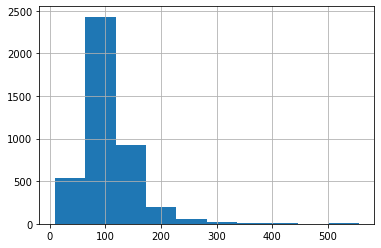

count    4190.000000
mean      106.225537
std        49.382846
min         9.000000
25%        77.000000
50%        98.000000
75%       124.000000
max       556.000000
dtype: float64

In [ ]:
'''
plot statistical features for trainset data
'''

import matplotlib.pyplot as plt
%matplotlib inline
train_title_len = [len(x) for x in text_int_train]
pd.Series(train_title_len).hist()
plt.show()
pd.Series(train_title_len).describe()

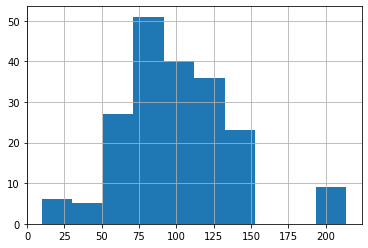

count    197.000000
mean     101.091371
std       38.807765
min       10.000000
25%       77.000000
50%       99.000000
75%      126.000000
max      214.000000
dtype: float64

In [ ]:
'''
plot statistical features for trainset data
'''

test_title_len = [len(x) for x in text_int_test]
pd.Series(test_title_len).hist()
plt.show()
pd.Series(test_title_len).describe()

In [ ]:
'''
remove very small or long texts in training dataset
'''

text_int_train = [ text_int_train[i] for i, l in enumerate(train_title_len) if l>0 ]
encoded_labels_train = [ augmented_train[1][i] for i, l in enumerate(train_title_len) if l> 0 ]

In [ ]:
'''
remove very small or long texts in testing dataset
'''

text_int_test = [ text_int_test[i] for i, l in enumerate(test_title_len) if l>0 ]
encoded_labels_test = [ augmented_test[1][i] for i, l in enumerate(test_title_len) if l> 0 ]

In [ ]:
'''
declare padding or cropping function for convert texts to fixed-size one
'''

import numpy as np
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = np.append(zeroes, review)
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [ ]:
'''
apply padding and cropping function to data
'''

text_int_train = pad_features(text_int_train,100)
text_int_test = pad_features(text_int_test,100)

In [ ]:
'''
convert python lists to numpy array for all news titles
'''

text_int_train = [np.array(text_int_train[i]) for i in range(len(text_int_train))]
text_int_test = [np.array(text_int_test[i]) for i in range(len(text_int_test))]

In [ ]:
'''
convert train and test set to numpy arrays and create one-hot encoding
format of labels
'''

train_x = np.array(text_int_train)
train_y = np.array(encoded_labels_train)
train_y = pd.get_dummies(encoded_labels_train).values

test_x = np.array(text_int_test)
test_y = np.array(encoded_labels_test)
test_y = pd.get_dummies(encoded_labels_test).values

In [ ]:
'''
define keras model for training
*convert all word vectors to fixed format: 400
our model is embedding+dropout+LSTM+Dense+softmax
we use categorical cross entropy loss function
'''

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
embedding_dim = 400

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 400)          6818000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 400)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 400)               1281600   
                                                                 
 dense (Dense)               (None, 3)                 1203      
                                                                 
Total params: 8,100,803
Trainable params: 8,100,803
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
'''
we train the model in 5 epochs with 64 batch size

we acquire about  76% accuracy for training phase and 52% accuracy for validation
'''

epochs = 5
batch_size = 64

history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
59/59 [==============================] - 185s 3s/step - loss: 0.9998 - accuracy: 0.5243 - val_loss: 1.0345 - val_accuracy: 0.4964
Epoch 2/5
59/59 [==============================] - 168s 3s/step - loss: 0.7167 - accuracy: 0.7003 - val_loss: 1.0607 - val_accuracy: 0.5322
Epoch 3/5
59/59 [==============================] - 168s 3s/step - loss: 0.5555 - accuracy: 0.7552 - val_loss: 1.1059 - val_accuracy: 0.5251
Epoch 4/5
59/59 [==============================] - 167s 3s/step - loss: 0.5014 - accuracy: 0.7616 - val_loss: 1.1267 - val_accuracy: 0.5203


In [ ]:
'''
test trained model on testing dataset, we acquire about 55% accuracy on testing data 
'''

accr = model.evaluate(test_x,test_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 3s 384ms/step - loss: 1.0466 - accuracy: 0.5533
Test set
  Loss: 1.047
  Accuracy: 0.553
